<a href="https://colab.research.google.com/github/GarlandZhang/hairy_gan/blob/master/hairy_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import os

import pandas as pd
import os
import shutil
if not os.path.exists('kaggle.json'):
  shutil.copy('/content/drive/My Drive/hairy_gan/kaggle.json', 'kaggle.json')
  # !pip install -q kaggle
  # files.upload()
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !kaggle datasets download -d jessicali9530/celeba-dataset --force
  !unzip celeba-dataset.zip
  !mv img_align_celeba celeba-dataset
  !mv list_eval_partition.csv celeba-dataset/list_eval_partition.csv
  !mv list_landmarks_align_celeba.csv celeba-dataset/list_landmarks_align_celeba.csv
  !mv list_attr_celeba.csv celeba-dataset/list_attr_celeba.csv
  !mv list_bbox_celeba.csv celeba-dataset/list_bbox_celeba.csv

  !mkdir celeba-dataset/trainA
  !mkdir celeba-dataset/trainB
  !mkdir celeba-dataset/validationA
  !mkdir celeba-dataset/validationB
  !mkdir celeba-dataset/testA
  !mkdir celeba-dataset/testB

  complete_df = pd.read_csv('celeba-dataset/list_attr_celeba.csv')
  partitions_df = pd.read_csv('celeba-dataset/list_eval_partition.csv') # 0 => train, 1 => validation, 2 => test
  for i, set_name in enumerate(['train', 'validation', 'test']):
    set_ids_df = partitions_df.loc[partitions_df['partition'] == i]['image_id']
    complete_df[complete_df['image_id'].isin(set_ids_df.tolist())]
    black_hair_ids = complete_df.loc[complete_df['Black_Hair'] == 1]['image_id'].tolist() # filters out black hair candidates
    blond_hair_ids = complete_df.loc[complete_df['Blond_Hair'] == 1]['image_id'].tolist() # filters out blond hair candidates
    for id in black_hair_ids:
      shutil.copy(os.path.join('celeba-dataset/img_align_celeba', id), os.path.join('celeba-dataset', f'{set_name}A', id))

    for id in blond_hair_ids:
      shutil.copy(os.path.join('celeba-dataset/img_align_celeba', id), os.path.join('celeba-dataset', f'{set_name}B', id))  

  !git clone https://www.github.com/keras-team/keras-contrib.git \
    && cd keras-contrib \
    && pip install git+https://www.github.com/keras-team/keras-contrib.git \
    && python convert_to_tf_keras.py \
    && USE_TF_KERAS=1 python setup.py install

  !pip install scipy==1.1.0

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197910.jpg  
  inflating: img_align_celeba/img_align_celeba/197911.jpg  
  inflating: img_align_celeba/img_align_celeba/197912.jpg  
  inflating: img_align_celeba/img_align_celeba/197913.jpg  
  inflating: img_align_celeba/img_align_celeba/197914.jpg  
  inflating: img_align_celeba/img_align_celeba/197915.jpg  
  inflating: img_align_celeba/img_align_celeba/197916.jpg  
  inflating: img_align_celeba/img_align_celeba/197917.jpg  
  inflating: img_align_celeba/img_align_celeba/197918.jpg  
  inflating: img_align_celeba/img_align_celeba/197919.jpg  
  inflating: img_align_celeba/img_align_celeba/197920.jpg  
  inflating: img_align_celeba/img_align_celeba/197921.jpg  
  inflating: img_align_celeba/img_align_celeba/197922.jpg  
  inflating: img_align_celeba/img_align_celeba/197923.jpg  
  inflating: img_align_celeba/img_align_celeba/197924.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [15]:
from __future__ import print_function, division
import scipy
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.optimizers import Adam
from keras.models import load_model

import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
from glob import glob
from PIL import Image

import tensorflow as tf
from tensorflow.python.keras.backend import set_session
# from tensorflow.python.keras.models import load_model
tf.compat.v1.enable_eager_execution()
# tf.compat.v1.disable_eager_execution()

from tqdm import tqdm

In [3]:
class DataLoader():
    def __init__(self, dataset_name, img_res):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = scipy.misc.imresize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = scipy.misc.imresize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob('%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = scipy.misc.imresize(img_A, self.img_res)
                img_B = scipy.misc.imresize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def imread(self, path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)

In [26]:
class HairyGan(): # based on CycleGan
  def __init__(self):
    
    # self.sess = tf.compat.v1.Session()
    # set_session(self.sess)
    
    # self.graph = tf.compat.v1.get_default_graph()
    
    # self.graph = tf.Graph()
    # self.graph2 = tf.Graph()

    self.img_rows = 128
    self.img_cols = 128
    self.img_channels = 3

    self.img_shape = (self.img_rows, self.img_cols, self.img_channels)
    
    patch = int(self.img_rows / 2**4)
    self.disc_out = (patch, patch, 1) # output shape of discriminator

    self.data_loader = DataLoader(dataset_name='celeba-dataset', img_res=(self.img_rows, self.img_cols))

    self.optimizer = Adam(0.0002, 0.5)

    if os.path.exists(os.path.join(project_path, 'd_A.hdf5')):
      self.d_A = load_model(os.path.join(project_path, 'd_A.hdf5'), custom_objects={'InstanceNormalization': InstanceNormalization})
    else:
      self.d_A = self.build_discriminator()
      self.d_A.compile(loss='mse', optimizer=self.optimizer, metrics=['accuracy'])

    if os.path.exists(os.path.join(project_path, 'd_B.hdf5')):
      self.d_B = load_model(os.path.join(project_path, 'd_B.hdf5'), custom_objects={'InstanceNormalization': InstanceNormalization})
    else:
      self.d_B = self.build_discriminator()
      self.d_B.compile(loss='mse', optimizer=self.optimizer, metrics=['accuracy'])

    if os.path.exists(os.path.join(project_path, 'g_AB.hdf5')):
      self.g_AB = load_model(os.path.join(project_path, 'g_AB.hdf5'), custom_objects={'InstanceNormalization': InstanceNormalization})
    else:
      self.g_AB = self.build_generator()

    if os.path.exists(os.path.join(project_path, 'g_BA.hdf5')):
      self.g_BA = load_model(os.path.join(project_path, 'g_BA.hdf5'), custom_objects={'InstanceNormalization': InstanceNormalization})
    else:
      self.g_BA = self.build_generator()

    self.combined_model = self.build_combined()

  def build_combined(self):
    lambda_cycle = 10.
    lambda_id = 0.9 * lambda_cycle

    img_A = Input(shape=self.img_shape) # image from domain A
    img_B = Input(shape=self.img_shape) # image from domain B

    fake_A = self.g_BA(img_B)
    fake_B = self.g_AB(img_A)
    
    reconstr_A = self.g_BA(fake_B)
    reconstr_B = self.g_AB(fake_A)

    id_A = self.g_BA(img_A)
    id_B = self.g_AB(img_B)


    self.d_A.trainable = False
    self.d_B.trainable = False

    valid_A = self.d_A(fake_A)
    valid_B = self.d_B(fake_B)

    combined = Model(
        inputs=[img_A, img_B],
        outputs=[valid_A, valid_B, reconstr_A, reconstr_B, id_A, id_B]
    )

    combined.compile(
        loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'],
        loss_weights=[1, 1, lambda_cycle, lambda_cycle, lambda_id, lambda_id],
        optimizer=self.optimizer
    )

    return combined

  def build_discriminator(self):

    def d_conv_block(layer_input, num_filt, f_size=4, normalization=True):
      d = Conv2D(num_filt, kernel_size=f_size, strides=2, padding='same')(layer_input)
      d = LeakyReLU(alpha=0.2)(d)
      if normalization:
        d = InstanceNormalization()(d)

      return d

    num_filt = 64

    img = Input(shape=self.img_shape)
    d1 = d_conv_block(img, num_filt, normalization=False)
    d2 = d_conv_block(d1, num_filt * 2)
    d3 = d_conv_block(d2, num_filt * 4)
    d4 = d_conv_block(d3, num_filt * 8)
    output = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model(img, output)

  def build_generator(self):
    def g_conv_block(layer_input, num_filt, f_size=4):
      d = Conv2D(num_filt, kernel_size=f_size, strides=2, padding='same')(layer_input)
      d = LeakyReLU(alpha=0.2)(d)
      d = InstanceNormalization()(d)
      return d

    def g_deconv_block(layer_input, skip_input, num_filt, f_size=4, dropout_rate=0):
      u = UpSampling2D(size=2)(layer_input)
      u = Conv2D(num_filt, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
      
      if dropout_rate:
        u = Dropout(dropout_rate)(u)
      
      u = InstanceNormalization()(u)
      u = Concatenate()([u, skip_input])

      return u

    num_filt = 32

    d0 = Input(shape=self.img_shape)
    d1 = g_conv_block(d0, num_filt)
    d2 = g_conv_block(d1, num_filt * 2)
    d3 = g_conv_block(d2, num_filt * 4)
    d4 = g_conv_block(d3, num_filt * 8)

    u1 = g_deconv_block(d4, d3, num_filt * 4)
    u2 = g_deconv_block(u1, d2, num_filt * 2)
    u3 = g_deconv_block(u2, d1, num_filt)

    u4 = UpSampling2D(size=2)(u3)
    output = Conv2D(self.img_channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

    return Model(d0, output)

  def train_fake(self, epochs, batch_size=1, sample_interval=50):

    # with self.graph.as_default():
    # discriminators
    self.d_A = self.build_discriminator()
    self.d_B = self.build_discriminator()

    self.d_A.compile(loss='mse', optimizer=self.optimizer, metrics=['accuracy'])
    self.d_B.compile(loss='mse', optimizer=self.optimizer, metrics=['accuracy'])

    # generators
    self.g_AB = self.build_generator()
    self.g_BA = self.build_generator()

    self.combined_model = self.build_combined()


    d_out_shape = (batch_size, ) + self.disc_out

    valid = np.ones(d_out_shape)
    fake = np.zeros(d_out_shape)

    # with self.graph.as_default():
      # set_session(self.sess)
    for epoch in range(epochs):
      batch_gen = self.data_loader.load_batch(batch_size)
      for i, elem in enumerate(batch_gen):
        break# hack to run function once

      steps_per_epoch = self.data_loader.n_batches - 2
      for step in tqdm(range(steps_per_epoch), desc=f'Train {epoch} / {epochs}', total=steps_per_epoch):
        batch_i = step

        imgs_A, imgs_B = next(batch_gen)

        fake_A = self.g_BA.predict(imgs_B)
        fake_B = self.g_AB.predict(imgs_A)

        real_A_history = self.d_A.fit(imgs_A, valid, batch_size=batch_size)
        fake_A_history = self.d_A.fit(fake_A, fake, batch_size=batch_size)
        # d_A_loss = 0.5 * np.add(real_A_loss, fake_A_loss)

        real_B_history = self.d_B.fit(imgs_B, valid, batch_size=batch_size)
        fake_B_history = self.d_B.fit(fake_B, fake, batch_size=batch_size)
        # d_B_loss = 0.5 * np.add(real_B_loss, fake_B_loss)

        # d_loss = 0.5 * np.add(d_A_loss, d_B_loss)

        g_history = self.combined_model.fit(
            [imgs_A, imgs_B],
            [fake, fake, imgs_A, imgs_B, imgs_A, imgs_B],
            batch_size=batch_size
        )

        if (batch_i + 1) % sample_interval == 0:
          self.sample_images(epoch, batch_i)
          project_path = '/content/drive/My Drive/hairy_gan'
          self.d_A.save('d_A.hdf5')
          shutil.copy('d_A.hdf5', os.path.join(project_path, 'd_A.hdf5'))

          self.d_B.save('d_B.hdf5')
          shutil.copy('d_B.hdf5', os.path.join(project_path, 'd_B.hdf5'))


          self.g_AB.save('g_AB.hdf5')
          shutil.copy('g_AB.hdf5', os.path.join(project_path, 'g_AB.hdf5'))

          self.g_BA.save('g_BA.hdf5')
          shutil.copy('g_BA.hdf5', os.path.join(project_path, 'g_BA.hdf5'))

  def train(self, epochs, batch_size=1, sample_interval=50):
    d_out_shape = (batch_size, ) + gan.disc_out

    valid = np.ones(d_out_shape)

    # sess = tf.compat.v1.Session()

    # with self.graph.as_default():
    self.d_A = self.build_discriminator()
    self.d_A.compile(loss='mse', optimizer=Adam(), metrics=['accuracy'])
    

    # with self.graph2.as_default():
    self.d_B = self.build_discriminator()
    self.d_B.compile(loss='mse', optimizer=Adam(), metrics=['accuracy'])

    # generators
    self.g_AB = self.build_generator()
    self.g_BA = self.build_generator()

    self.combined_model = self.build_combined()


    d_out_shape = (batch_size, ) + self.disc_out

    valid = np.ones(d_out_shape)
    fake = np.zeros(d_out_shape)

    batch_gen = self.data_loader.load_batch(batch_size)
    for epoch in range(epochs):
      batch_gen = self.data_loader.load_batch(batch_size)
      for i, elem in enumerate(batch_gen):
        break# hack to run function once

      steps_per_epoch = self.data_loader.n_batches - 2
      for step in tqdm(range(steps_per_epoch), desc=f'Train {epoch} / {epochs}', total=steps_per_epoch):
        batch_i = step

        imgs_A, imgs_B = next(batch_gen)

        fake_A = self.g_BA.predict(imgs_B)
        fake_B = self.g_AB.predict(imgs_A)

        real_A_history = self.d_A.fit(imgs_A, valid, batch_size=batch_size)
        fake_A_history = self.d_A.fit(fake_A, fake, batch_size=batch_size)
        # d_A_loss = 0.5 * np.add(real_A_loss, fake_A_loss)

        real_B_history = self.d_B.fit(imgs_B, valid, batch_size=batch_size)
        fake_B_history = self.d_B.fit(fake_B, fake, batch_size=batch_size)
        # d_B_loss = 0.5 * np.add(real_B_loss, fake_B_loss)

        # d_loss = 0.5 * np.add(d_A_loss, d_B_loss)

        g_history = self.combined_model.fit(
            [imgs_A, imgs_B],
            [fake, fake, imgs_A, imgs_B, imgs_A, imgs_B],
            batch_size=batch_size
        )

        if (batch_i + 1) % sample_interval == 0:
          self.sample_images(epoch, batch_i)
          
          self.d_A.save('d_A.hdf5')
          shutil.copy('d_A.hdf5', os.path.join(project_path, 'd_A.hdf5'))

          self.d_B.save('d_B.hdf5')
          shutil.copy('d_B.hdf5', os.path.join(project_path, 'd_B.hdf5'))


          self.g_AB.save('g_AB.hdf5')
          shutil.copy('g_AB.hdf5', os.path.join(project_path, 'g_AB.hdf5'))

          self.g_BA.save('g_BA.hdf5')
          shutil.copy('g_BA.hdf5', os.path.join(project_path, 'g_BA.hdf5'))

  def sample_images(self):
    rows, cols = 2, 3

    imgs_A = self.data_loader.load_data(domain='A', batch_size=1, is_testing=True)
    imgs_B = self.data_loader.load_data(domain='B', batch_size=1, is_testing=True)

    fake_A = self.g_BA.predict(imgs_B)
    fake_B = self.g_AB.predict(imgs_A)

    reconstr_A = self.g_BA.predict(fake_B)
    reconstr_B = self.g_AB.predict(fake_A)

    gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

    gen_imgs = 0.5 * gen_imgs + 0.5

    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axes = plt.subplots(rows, cols)

    count = 0

    for i in range(rows):
      for j in range(cols):
        axes[i, j].imshow(gen_imgs[count])
        axes[i, j].set_title(titles[j])
        axes[i, j].axis('off')
        count += 1

    plt.show()
    

In [29]:
project_path = '/content/drive/My Drive/hairy_gan'
gan = HairyGan()
# gan.train(epochs=100, batch_size=64, sample_interval=100)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [23]:
gan.g_AB = load_model('/content/drive/My Drive/hairy_gan/g_AB.hdf5', custom_objects={'InstanceNormalization': InstanceNormalization})
gan.g_BA = load_model('/content/drive/My Drive/hairy_gan/g_BA.hdf5', custom_objects={'InstanceNormalization': InstanceNormalization})

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


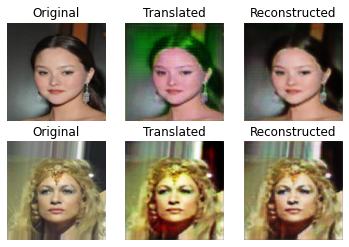

In [30]:
gan.sample_images()